In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "/O2 /fp:fast /openmp")

S = 512

def transpose(A):
    N, M = A.shape
    i, j = tf.indices([M, N])
    return A[j, i] * 1.0

def matmul():
    A = tf.input([-1, -1], tf.float32)
    B = tf.input([-1, -1], tf.float32)

    N, M = A.shape
    K = B.shape[1]
    
    C = tf.zeros([N, K])
    Bt = transpose(B)

    i, j, k = tf.indices([N, K, M])

    tf.scatterAdd(C[i, j], A[i, k] * Bt[j, k])

    return [C]

mmul = tf.program(matmul)

TensorFrost module loaded!
TensorProgram:
  Kernel count: 3
  Intermediate buffers: 6
  Lines of generated code: 137
  IR size: 83



In [6]:
Anp = np.random.rand(64, 32).astype(np.float32)
Bnp = np.random.rand(32, 48).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)
print(Cnp - Cnp2)


[[ 8.841384  11.003944   8.813161  ... 10.016073   8.3756275  8.416511 ]
 [ 7.9930086  9.087204   7.854289  ...  8.022899   8.015229   8.518088 ]
 [ 8.620032  10.570232   8.065367  ...  9.833999   9.154392   8.301198 ]
 ...
 [ 9.046192  10.360286   9.057479  ...  9.586142   8.281228   9.934722 ]
 [ 9.498294  10.672377  10.127481  ... 10.835852   8.415052   9.890973 ]
 [ 9.440323  11.095591   8.871891  ...  9.900028  10.115834   9.027037 ]]
[[ 8.841383  11.003944   8.813162  ... 10.016072   8.3756275  8.416511 ]
 [ 7.9930086  9.087205   7.8542886 ...  8.0229     8.015228   8.518088 ]
 [ 8.620031  10.570232   8.065367  ...  9.834      9.154392   8.301196 ]
 ...
 [ 9.046194  10.360288   9.05748   ...  9.58614    8.281228   9.934721 ]
 [ 9.498295  10.672377  10.127481  ... 10.835854   8.4150505  9.890974 ]
 [ 9.440321  11.095589   8.87189   ...  9.900028  10.115833   9.027036 ]]
[[ 9.5367432e-07  0.0000000e+00 -9.5367432e-07 ...  9.5367432e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e

In [3]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)

def TestFunc(f1, max_time):
    t0 = time.time()
    i = 0
    while time.time() - t0 < max_time:
        f1()
        i += 1
    return (time.time() - t0) / i

# Performance test
def TensorFrost():
    C, = mmul(A, B)

def Numpy():
    Cnp2 = Bnp @ Anp

np_time = TestFunc(Numpy, 10)
print("Numpy: ", np_time)

tf_time = TestFunc(TensorFrost, 10)
print("TensorFrost: ", tf_time)

print("TF/NP: ", tf_time / np_time)

Numpy:  0.0009382623381497466
TensorFrost:  0.048723292582243394
TF/NP:  51.92928523415501


In [4]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.memory(Anp)
    B = tf.memory(Bnp)

    # Performance test
    def TensorFrost():
        C, = mmul(A, B)
    
    def Numpy():
        Cnp2 = Bnp @ Anp

    tf_time = TestFunc(TensorFrost, 1)
    np_time = TestFunc(Numpy, 1)

    return tf_time, np_time

sizes = [2**i for i in range(4, 12)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

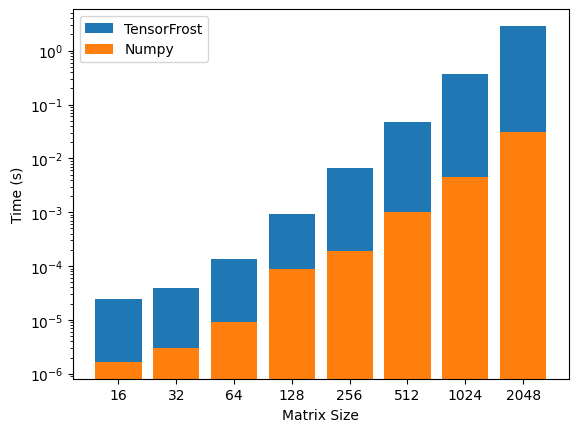

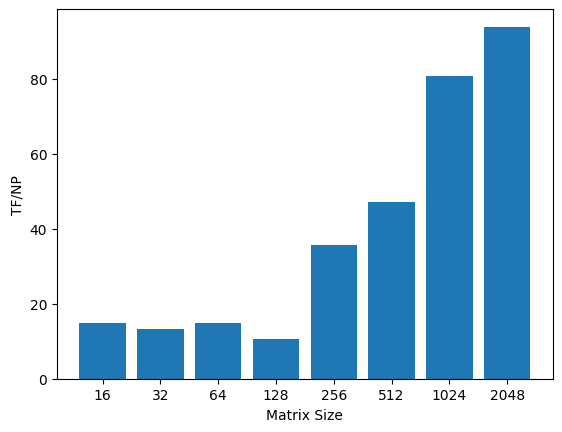

[2.473596738996998e-05, 3.9485619009930654e-05, 0.00013512389062547787, 0.0009277087875380353, 0.006718118718806529, 0.04766653832935151, 0.36933358510335285, 2.8819997310638428]
[1.6593107862120916e-06, 2.956502768049325e-06, 9.040221175472232e-06, 8.759637687618948e-05, 0.00018782887935280172, 0.0010090834197074205, 0.004579904416924742, 0.030697042291814632]


In [5]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)